In [5]:
import numpy as np

def load_mnist_images(filename):
    with open(filename, 'rb') as file:
        data = np.fromfile(file, dtype=np.uint8)
        data = data[16:]  # Skip the header
        data = data.reshape(-1, 28, 28)  # Reshape to 28x28 images
    return data

def load_mnist_labels(filename):
    with open(filename, 'rb') as file:
        data = np.fromfile(file, dtype=np.uint8)
        data = data[8:]  # Skip the header
    return data

train_images = load_mnist_images('data/train-images.idx3-ubyte')
train_labels = load_mnist_labels('data/train-labels.idx1-ubyte')
test_images = load_mnist_images('data/t10k-images.idx3-ubyte')
test_labels = load_mnist_labels('data/t10k-labels.idx1-ubyte')

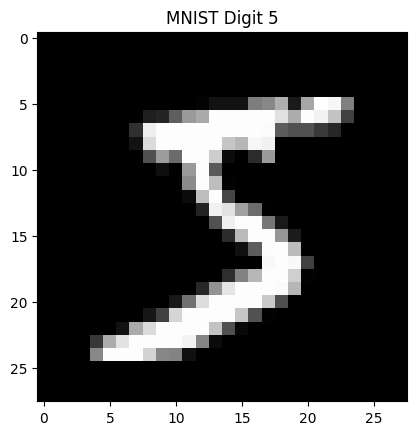

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Load the MNIST image data
def load_mnist_images(filename):
    with open(filename, 'rb') as file:
        data = np.fromfile(file, dtype=np.uint8)
        data = data[16:]  # Skip the header
        data = data.reshape(-1, 28, 28)  # Reshape to 28x28 images
    return data

# Load the training images
train_images = load_mnist_images('data/train-images.idx3-ubyte')

# Choose an image to visualize (e.g., the first image)
image_to_visualize = train_images[0]

# Display the image using Matplotlib
plt.imshow(image_to_visualize, cmap='gray')
plt.title(f'MNIST Digit {train_labels[0]}')  # Assuming you also have the labels
plt.show()

In [10]:
import tensorflow as tf

2023-10-14 12:07:56.377798: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-14 12:07:56.593116: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-14 12:07:56.593197: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-14 12:07:56.594609: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-14 12:07:56.702065: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-14 12:07:56.703085: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [11]:
tf.__version__

'2.14.0'

In [13]:
import glob
#import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

In [14]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 2s 0us/step


In [15]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

In [16]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [17]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [18]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

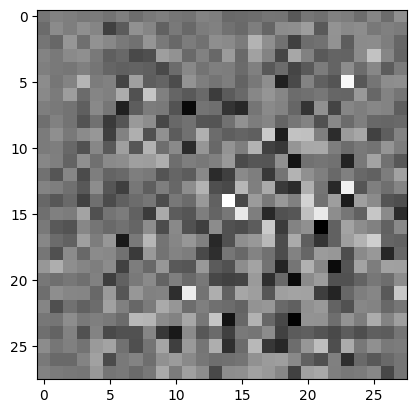

In [19]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [20]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [21]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.00169566]], shape=(1, 1), dtype=float32)


In [22]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [23]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss